In [20]:
from yahooquery import Ticker
import yfinance as yf 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def get_returns_df(ticker:str, period:str= "max"):
    # Download data and return as pd "Date, Returns"

    try:
        data = yf.download(
            tickers=ticker,
            period=period)
        
        if data is None or data.empty:
            print(f"No data returned for ticker: '{ticker}'.")
            return pd.DataFrame()
        
        raw_df = data["Close"].pct_change().dropna()
        raw_df = raw_df.reset_index().set_index("Date")
        clean_df = raw_df.set_axis(['Returns'], axis=1)
        return clean_df
    
    except ValueError as e:
        print(f"Error Downloading Data: {e}")
        return pd.DataFrame()
    
ticker_input = "AAPL"
period_input = "1y"

data = get_returns_df("AAPL")
data


C:\Users\Justin\AppData\Local\Temp\ipykernel_18312\2181721471.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(
[*********************100%***********************]  1 of 1 completed


,Returns
Date,
1980-12-15,-0.052171
1980-12-16,-0.073398
1980-12-17,0.024751
1980-12-18,0.028993
1980-12-19,0.061029
...,...
2025-11-17,-0.018171
2025-11-18,-0.000075
2025-11-19,0.004188


In [2]:
returns = df["adjclose"].pct_change().dropna()
log_returns = np.log(returns + 1)


In [3]:
def compute_log_returns(df, price_col="adjclose"):
    prices = df[price_col]
    log_returns = np.log(prices / prices.shift(1))
    return log_returns.dropna()

log_returns = compute_log_returns(df)

In [6]:
train_df = df.iloc[:-30]
log_returns = compute_log_returns(train_df)

# daily drift (μ) and volatility (σ)
mu_daily = log_returns.mean()
sigma_daily = log_returns.std()

# if you want annualized:
mu_annual = mu_daily * 252
sigma_annual = sigma_daily * np.sqrt(252)

print(f"mu_daily: {mu_daily} | sigma_daily: {sigma_daily}")
print(f"mu_annual: {mu_annual} | sigma_annual: {sigma_annual}")

train_df.head(20)

mu_daily: 0.0010407327486936103 | sigma_daily: 0.015445444247063303
mu_annual: 0.2622646526707898 | sigma_annual: 0.24518882619985666


,adjclose
date,
2024-11-15,411.907623
2024-11-18,412.661926
2024-11-19,414.676788
2024-11-20,412.393951
2024-11-21,410.613739
2024-11-22,414.721161
2024-11-25,416.501373
2024-11-26,425.651093
2024-11-27,420.678406


ValueError: x and y must have same first dimension, but have shapes (36,) and (1,)

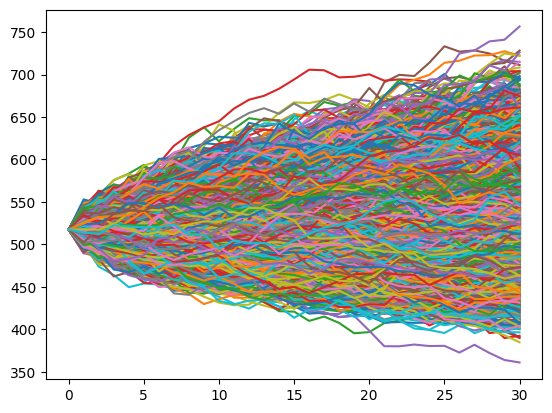

In [5]:
e = 25_000

last_price = train_df["adjclose"].iloc[-1]
n_days = 30

dt = 1  
mu = mu_daily
sigma = sigma_daily

data = {}
for i in range(e):
    prices = [last_price]
    for _ in range(n_days):
        eps = np.random.normal()
        next_price = prices[-1] * np.exp((mu - 0.5 * sigma**2) * dt 
                                         + sigma * np.sqrt(dt) * eps)
        prices.append(next_price)

    data[f"Sim_{i}"] = prices

sim_df = pd.DataFrame(data)
# sim_df.plot(
#     legend=False, 
#     title=f"Monte Carlo AAPL Stock Simulation With {e} Simulations",
#     xlabel="Simulation Day",
#     ylabel="Simulated Price"
# )


# Create x-axes
x1 = np.arange(-5, 31)          # -5 to 30
x2 = np.arange(0, 31)            # 0 to 30

plt.plot(x2, sim_df)
plt.plot(x1, train_df["adjclose"].iloc[-1], color="black")
plt.axhline(train_df["adjclose"].tail(36)[-1], color="black", linestyle="--", alpha=0.7, label=f"Break Even Line")
plt.plot()


/var/folders/cr/vk1gr2j557sfbvd9fb20cz3r0000gn/T/ipykernel_27305/1449097323.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  day_zero_price = round(float(train_df["adjclose"].tail(36)[-1]),2)


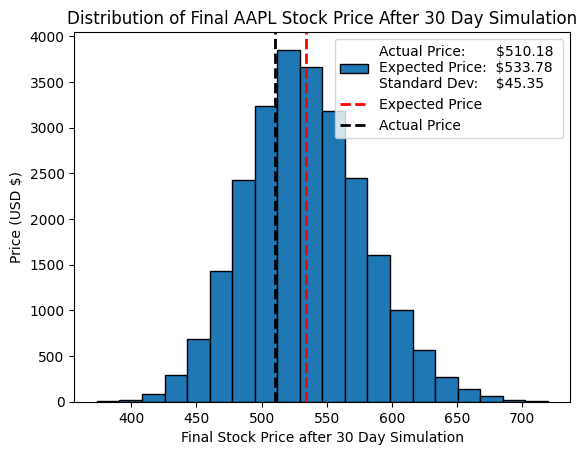

517.35
510.18
ROI: If bought at day 0 and sold at day 30: -1.41%


In [ ]:
data = np.array(sim_df.iloc[-1:].values.flatten())

mean = data.mean()
std = data.std()

final_price = round(float(df["adjclose"].tail(1).item()),2)
day_zero_price = round(float(train_df["adjclose"].tail(36)[-1]),2)

plt.hist(data, bins=20,edgecolor='black', 
         label=f"Actual Price:       ${final_price} \nExpected Price:  ${round(mean,2)} \nStandard Dev:    ${round(std,2)}")


plt.axvline(x=mean, color='red', linestyle='--', linewidth=2, label='Expected Price')
plt.axvline(x=final_price, color='black', linestyle='--', linewidth=2, label='Actual Price')
plt.title(f"Distribution of Final AAPL Stock Price After 30 Day Simulation")
plt.xlabel("Final Stock Price after 30 Day Simulation")
plt.ylabel("Price (USD $)")
plt.legend()
plt.show()

print(day_zero_price)
print(final_price)
print(f"ROI: If bought at day 0 and sold at day 30: {round(((final_price - day_zero_price) / final_price) * 100,2)}%")

In [ ]:
print(f"Last Actual price:                  | ${round(last_price,2)}")
print(f"Expected Price After 30 Day's:      | ${round(mean,2)}\n")
# ---------------------------------997----------------------------------------
lower_bound_997 = mean - 2.58 * std
upper_bound_997 = mean + 2.58 * std

# 99.7% CI of Expected Value
range = [float(lower_bound_997), float(upper_bound_997)]

print(f"99.7% CI of Expected Value: {range}")

# ---------------------------------95----------------------------------------
lower_bound_95 = mean - 1.96 * std
upper_bound_95 = mean + 1.96 * std

# 95% CI of Expected Value
range = [float(lower_bound_95), float(upper_bound_95)]

print(f"95% CI of Expected Value: {range}")


# ---------------------------------68----------------------------------------
lower_bound_68 = mean - 1 * std
upper_bound_68 = mean + 1 * std

# 66% CI of Expected Value
range = [float(lower_bound_68), float(upper_bound_68)]

print(f"68% CI of Expected Value: {range}")

Last Actual price:                  | $517.35
Expected Price After 30 Day's:      | $533.78

99.7% CI of Expected Value: [416.78384430496845, 650.7752869382725]
95% CI of Expected Value: [444.8990951640088, 622.6600360792321]
68% CI of Expected Value: [488.4323868167166, 579.1267444265244]
